<a href="https://colab.research.google.com/github/Shivam-Miglani/learn-datascience/blob/master/word2vec_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec
here I implement word2vec with very simple example using tensorflow  
word2vec is vector representation for words with similarity

# Collect Data
we will use only 10 sentences to create word vectors

In [0]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# Remove stop words
In order for efficiency of creating word vector, we will remove commonly used words

In [0]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [0]:
corpus = remove_stop_words(corpus)

In [0]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

here we have word set by which we will have word vector

In [0]:
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

# data generation
we will generate label for each word using skip gram.  

In [0]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [0]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [0]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [0]:
df.shape

(52, 2)

In [0]:
word2int

{'boy': 5,
 'girl': 7,
 'king': 1,
 'man': 2,
 'pretty': 11,
 'prince': 0,
 'princess': 8,
 'queen': 10,
 'strong': 9,
 'wise': 4,
 'woman': 6,
 'young': 3}

# Define Tensorflow Graph

In [0]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2 

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


# Train

In [0]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.810159
iteration 3000 loss is :  1.8507849
iteration 6000 loss is :  1.7723882
iteration 9000 loss is :  1.7433149
iteration 12000 loss is :  1.7285424
iteration 15000 loss is :  1.7190398
iteration 18000 loss is :  1.712226


In [0]:
# Now the hidden layer (W1 + b1) is actually the word look up table
vectors = sess.run(W1 + b1)
print(vectors)

[[ 4.7959633   2.9895568 ]
 [ 0.98337406 -0.01687241]
 [ 0.74061227 -0.1766417 ]
 [ 0.22953522  0.3828776 ]
 [ 0.02719247  6.2142015 ]
 [ 2.0363803   0.6293089 ]
 [-0.24975741  0.11185968]
 [ 0.17684007  1.8860458 ]
 [ 1.8683412   5.204715  ]
 [ 6.8462214   0.36102164]
 [-0.34639478  0.6425283 ]
 [-2.2812495   4.1653476 ]]


# word vector in table

In [0]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,prince,4.795963,2.989557
1,king,0.983374,-0.016872
2,man,0.740612,-0.176642
3,young,0.229535,0.382878
4,wise,0.027192,6.214201
5,boy,2.036380,0.629309
6,woman,-0.249757,0.111860
7,girl,0.176840,1.886046
8,princess,1.868341,5.204715
9,strong,6.846221,0.361022


# word vector in 2d chart

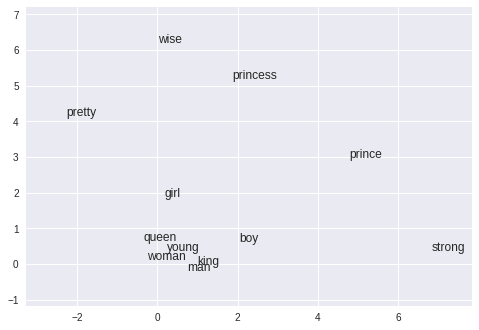

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()